## Multi Head Attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

d:\software\anaconda\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [39]:
x.size()

torch.Size([1, 4, 512])

In [40]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [41]:
qkv = qkv_layer(x)

In [42]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

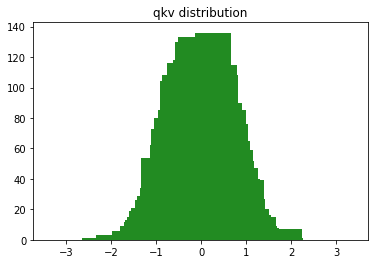

In [43]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [44]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [45]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [48]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [49]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [50]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [52]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [53]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.4146,  1.1240],
        [-0.0925,  0.0419],
        [-1.1873,  0.4655]])

In [54]:
torch.transpose(y, 1, 0)

tensor([[-0.4146,  1.1240],
        [-0.0925,  0.0419],
        [-1.1873,  0.4655]])

In [55]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [56]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [57]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [58]:
(scaled + mask)[0][0]

tensor([[-0.0611,    -inf,    -inf,    -inf],
        [ 0.5596,  0.0404,    -inf,    -inf],
        [ 0.1348, -0.0516,  0.3945,    -inf],
        [ 0.0038,  0.5560, -0.2397,  0.4025]], grad_fn=<SelectBackward0>)

In [59]:
scaled += mask

In [61]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [62]:
attention = F.softmax(scaled, dim=-1)

In [63]:
attention.shape

torch.Size([1, 8, 4, 4])

In [64]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6270, 0.3730, 0.0000, 0.0000],
        [0.3198, 0.2655, 0.4147, 0.0000],
        [0.1996, 0.3467, 0.1564, 0.2973]], grad_fn=<SelectBackward0>)

In [65]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [2]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [79]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [80]:
attention.shape

torch.Size([1, 8, 4, 4])

In [81]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6270, 0.3730, 0.0000, 0.0000],
        [0.3198, 0.2655, 0.4147, 0.0000],
        [0.1996, 0.3467, 0.1564, 0.2973]], grad_fn=<SelectBackward0>)

In [70]:
values.size()

torch.Size([1, 8, 4, 64])

In [71]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [72]:
linear_layer = nn.Linear(d_model, d_model)

In [73]:
out = linear_layer(values)

In [74]:
out.shape

torch.Size([1, 4, 512])

In [75]:
out

tensor([[[ 0.0687,  0.0984,  0.0381,  ...,  0.1252,  0.0707, -0.0547],
         [-0.0399,  0.0419, -0.0933,  ...,  0.3064,  0.1585,  0.0599],
         [-0.0684, -0.0657,  0.2306,  ...,  0.0606,  0.0670,  0.0293],
         [ 0.0781, -0.0159, -0.0343,  ...,  0.0074, -0.1094, -0.0365]]],
       grad_fn=<ViewBackward0>)

## Class

In [3]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [4]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
